In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors

# Read data

In [2]:
df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2.parquet')

In [3]:
# Timing 

df_time_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_aps_aih.parquet')

df_time_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_otc_aih.parquet')

In [4]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)


# Pre process data

In [5]:
# Create a dictionary to map old names to new names
rename_dict = {col: col + '_otc' for col in df_time_otc.columns}

# Apply renaming to the DataFrame (assuming df is your DataFrame)
df_time_otc = df_time_otc.rename(columns=rename_dict)

df_time_otc = df_time_otc.rename(columns = {'co_imed_otc': 'co_imed'})

In [6]:
dta1 = df_time_otc.merge(df_time_aps[['co_imed', 'n3', 'n2', 'n1', 'n0', 'n1_after', 'missed', 'TP', 'TN1',
       'FP1', 'FN']], on = 'co_imed', how = 'left')

In [7]:
dta1['co_imed'] = dta1['co_imed'].astype(str)

In [8]:
# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  
gdf['co_imed'] = gdf['co_imed'].astype(str)

# Merge the shapefile with your data
gdf = gdf.merge(dta1, on='co_imed', how='left')

# Indicator to define best data per reagion 

## Based only on timely anticipation

In [9]:
# Define the weights
#weights = {"n3_otc": 0.4, "n2_otc": 0.3, "n1_otc": 0.2, "n0_otc": 0.1} 

# Compute the anticipation score
gdf["anticipation_score_otc"] = (
    gdf["n3_otc"] + gdf["n2_otc"] + gdf["n1_otc"] + gdf["n0_otc"] 
    ) / gdf["total_aih_warning_otc"]

#* weights["n3_otc"] +#* weights["n2_otc"] +#* weights["n1_otc"] +#* weights["n0_otc"]

# Ensure score is between 0 and 1
gdf["anticipation_score_otc"] = gdf["anticipation_score_otc"].clip(0, 1)

gdf["anticipation_score_otc"] = gdf["anticipation_score_otc"].fillna(0)

In [10]:
#gdf

In [11]:
# Define the weights
#weights = {"n3": 0.4, "n2": 0.3, "n1": 0.2, "n0": 0.1} #"missed": -0.5

# Compute the anticipation score
gdf["anticipation_score_aps"] = (
    gdf["n3"] +
    gdf["n2"]  +
    gdf["n1"]  +
    gdf["n0"]  #+
    #gdf["n1_after"] * weights["n1_after"] +
    #gdf["missed"] * weights["missed"]
) / gdf["total_aih_warning_otc"]

# Ensure score is between 0 and 1
gdf["anticipation_score_aps"] = gdf["anticipation_score_aps"].clip(0, 1)
gdf["anticipation_score_aps"] = gdf["anticipation_score_aps"].fillna(0)

In [13]:
#gdf

In [14]:
gdf.anticipation_score_otc.describe()

count    510.000000
mean       0.545425
std        0.467984
min        0.000000
25%        0.000000
50%        0.666667
75%        1.000000
max        1.000000
Name: anticipation_score_otc, dtype: float64

In [15]:
gdf.anticipation_score_aps.describe()

count    510.000000
mean       0.496405
std        0.464569
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: anticipation_score_aps, dtype: float64

In [34]:
# Define percentile-based thresholds
threshold = 0.6  # You can adjust this

def categorize_region(row):
    if row["anticipation_score_otc"] >= threshold and row["anticipation_score_aps"] >= threshold:
        return "Both high"
    elif row["anticipation_score_otc"] >= threshold:
        return "OTC higher"
    elif row["anticipation_score_aps"] >= threshold:
        return "PHC higher"
    else:
        return "Both low"

# Apply function to create the category column
gdf["anticipation_category"] = gdf.apply(categorize_region, axis=1)


In [35]:
#gdf["anticipation_category"].value_counts()

In [36]:
gdf[gdf['missed_otc'].notnull()]["anticipation_category"].value_counts()

Both high     161
OTC higher     95
Both low       84
PHC higher     63
Name: anticipation_category, dtype: int64

In [37]:
# Print summary
round(gdf[gdf['missed_otc'].notnull()]["anticipation_category"].value_counts()*100/510,1)

Both high     31.6
OTC higher    18.6
Both low      16.5
PHC higher    12.4
Name: anticipation_category, dtype: float64

In [40]:
510 -403

107

In [32]:
#gdf[gdf["anticipation_category"] == 'Both good'][['anticipation_score_otc','anticipation_score_aps','anticipation_category']]

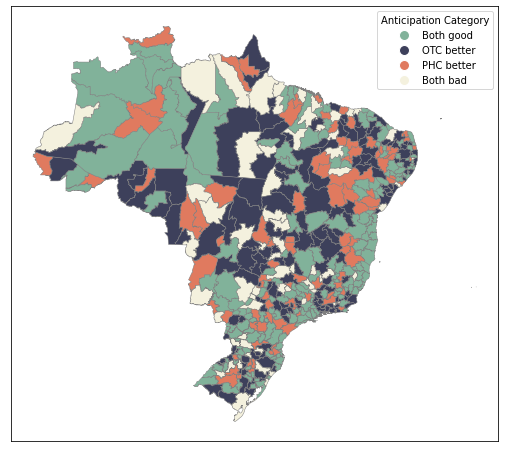

In [17]:
# Define a color mapping for categories
category_colors = {
    "Both good": "#81B29A",  # muted sage green 
    "OTC better": "#3D405B",  # deep slate blue 
    "PHC better": "#E07A5F",  # terra cotta 
    "Both bad": "#F4F1DE"  # antique white
}


# Ensure 'anticipation_category' is categorical
gdf["anticipation_category"] = gdf["anticipation_category"].astype("category")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the regions based on the category
gdf.plot(column="anticipation_category",
         cmap=mcolors.ListedColormap(category_colors.values()),  
         linewidth=0.5,
         ax=ax,
         edgecolor="gray",
         legend=False)  # We'll add a custom legend instead

# Add a custom legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markersize=10,
                       markerfacecolor=category_colors[cat], label=cat) for cat in category_colors]

ax.legend(handles=handles, title="Anticipation Category", loc="upper right")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title("Regional Classification by Anticipation Category", fontsize=14)

# Show plot
plt.show()


## Based on precision

In [41]:
Precision_otc = (gdf.TP_otc + gdf.TN1_otc) / (gdf.TP_otc + gdf.TN1_otc + gdf.FP1_otc + gdf.FN_otc) 

In [43]:
gdf = gdf.assign(pre_otc = Precision_otc.fillna(0))

In [44]:
Precision_aps = (gdf.TP + gdf.TN1) / (gdf.TP + gdf.TN1 + gdf.FP1 + gdf.FN) 

In [45]:
gdf = gdf.assign(pre_aps = Precision_aps.fillna(0))

In [46]:
gdf.pre_otc.median()

0.46788990825688076

In [47]:
gdf.pre_aps.median()

0.5181818181818182

In [48]:
# Define precision thresholds
pre_threshold_phc = gdf.pre_aps.median()
pre_threshold_otc = gdf.pre_otc.median()

# Function to assign categories based on precision only
def categorize_performance(row):
    phc_good = row["pre_aps"] >= pre_threshold_phc
    otc_good = row["pre_otc"] >= pre_threshold_otc
    
    if phc_good and otc_good:
        return "Both high"
    elif phc_good:
        return "PHC higher"
    elif otc_good:
        return "OTC higher"
    else:
        return "Both low"

# Apply function to create the new categorical variable
gdf["anticipation_category2"] = gdf.apply(categorize_performance, axis=1)


In [51]:
#gdf[gdf['missed_otc'].notnull()]

In [52]:
round(gdf[gdf['missed_otc'].notnull()]["anticipation_category2"].value_counts()*100/510,1)

Both high     32.2
PHC higher    18.6
OTC higher    18.0
Both low      10.2
Name: anticipation_category2, dtype: float64

In [53]:
# Print summary
gdf[gdf['missed_otc'].notnull()]["anticipation_category2"].value_counts()

Both high     164
PHC higher     95
OTC higher     92
Both low       52
Name: anticipation_category2, dtype: int64

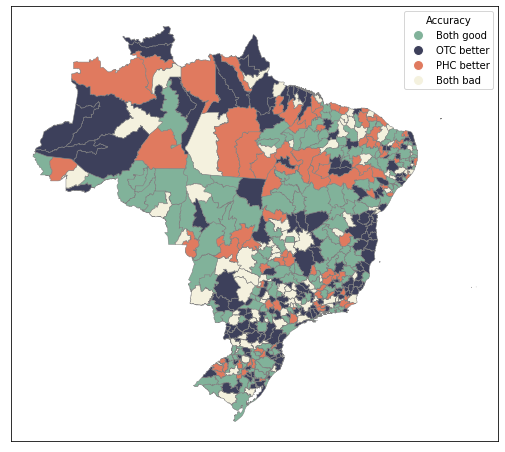

In [54]:
# Define a color mapping for categories
category_colors = {
    "Both good": "#81B29A",  # muted sage green 
    "OTC better": "#3D405B",  # deep slate blue 
    "PHC better": "#E07A5F",  # terra cotta 
    "Both bad": "#F4F1DE"  # antique white
}


# Ensure 'anticipation_category' is categorical
gdf["anticipation_category2"] = gdf["anticipation_category2"].astype("category")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the regions based on the category
gdf.plot(column="anticipation_category2",
         cmap=mcolors.ListedColormap(category_colors.values()),  
         linewidth=0.5,
         ax=ax,
         edgecolor="gray",
         legend=False)  # We'll add a custom legend instead

# Add a custom legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markersize=10,
                       markerfacecolor=category_colors[cat], label=cat) for cat in category_colors]

ax.legend(handles=handles, title="Accuracy", loc="upper right")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title("Regional Classification by Accuracy", fontsize=14)

# Show plot
plt.show()


In [55]:
gdf.anticipation_score_otc.describe()

count    510.000000
mean       0.545425
std        0.467984
min        0.000000
25%        0.000000
50%        0.666667
75%        1.000000
max        1.000000
Name: anticipation_score_otc, dtype: float64

In [56]:
gdf.anticipation_score_aps.describe()

count    510.000000
mean       0.496405
std        0.464569
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: anticipation_score_aps, dtype: float64

In [57]:
gdf

,rgi,nome_rgi,geometry,co_imed,n3_otc,n2_otc,n1_otc,n0_otc,n1_after_otc,missed_otc,...,TP,TN1,FP1,FN,anticipation_score_otc,anticipation_score_aps,anticipation_category,pre_otc,pre_aps,anticipation_category2
0,110001,Porto Velho,"POLYGON Z ((-63.32721 -7.97672 0.00000, -63.11...",110001,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,58.0,51.0,0.0,1.0,1.0,Both high,0.527273,0.536364,Both high
1,110002,Ariquemes,"POLYGON Z ((-62.48851 -8.73008 0.00000, -62.48...",110002,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,56.0,53.0,0.0,1.0,1.0,Both high,0.590909,0.518182,Both high
2,110003,Jaru,"POLYGON Z ((-62.22055 -8.59088 0.00000, -62.21...",110003,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,66.0,42.0,1.0,1.0,0.5,OTC higher,0.636364,0.609091,Both high
3,110004,Ji-Paraná,"POLYGON Z ((-61.57450 -9.72063 0.00000, -61.57...",110004,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,61.0,47.0,0.0,1.0,1.0,Both high,0.590909,0.572727,Both high
4,110005,Cacoal,"POLYGON Z ((-61.42731 -10.98755 0.00000, -61.0...",110005,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,59.0,49.0,1.0,0.5,0.5,Both low,0.481818,0.545455,Both high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,520019,Luziânia,"POLYGON Z ((-48.36389 -15.81896 0.00000, -48.3...",520019,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,59.0,50.0,1.0,1.0,0.0,OTC higher,0.463636,0.536364,PHC higher
506,520020,Águas Lindas de Goiás,"POLYGON Z ((-47.14176 -14.53552 0.00000, -47.1...",520020,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,57.0,51.0,0.0,1.0,1.0,Both high,0.445455,0.536364,PHC higher
507,520021,Posse-Campos Belos,"POLYGON Z ((-46.41484 -12.82778 0.00000, -46.4...",520021,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,54.0,55.0,0.0,1.0,1.0,Both high,0.409091,0.500000,Both low
508,520022,Flores de Goiás,"POLYGON Z ((-47.63129 -13.10818 0.00000, -47.6...",520022,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,Both low,0.000000,0.000000,Both low


In [58]:
dta_save =gdf[['rgi', 'nome_rgi', 'geometry', 'co_imed', 'anticipation_category', 
       'anticipation_category2','n3_otc']].rename(columns={'anticipation_category':'anticipation', 
                                                 'anticipation_category2':'precision'})

In [59]:
dta_save

,rgi,nome_rgi,geometry,co_imed,anticipation,precision,n3_otc
0,110001,Porto Velho,"POLYGON Z ((-63.32721 -7.97672 0.00000, -63.11...",110001,Both high,Both high,0.0
1,110002,Ariquemes,"POLYGON Z ((-62.48851 -8.73008 0.00000, -62.48...",110002,Both high,Both high,1.0
2,110003,Jaru,"POLYGON Z ((-62.22055 -8.59088 0.00000, -62.21...",110003,OTC higher,Both high,1.0
3,110004,Ji-Paraná,"POLYGON Z ((-61.57450 -9.72063 0.00000, -61.57...",110004,Both high,Both high,2.0
4,110005,Cacoal,"POLYGON Z ((-61.42731 -10.98755 0.00000, -61.0...",110005,Both low,Both high,1.0
...,...,...,...,...,...,...,...
505,520019,Luziânia,"POLYGON Z ((-48.36389 -15.81896 0.00000, -48.3...",520019,OTC higher,PHC higher,1.0
506,520020,Águas Lindas de Goiás,"POLYGON Z ((-47.14176 -14.53552 0.00000, -47.1...",520020,Both high,PHC higher,2.0
507,520021,Posse-Campos Belos,"POLYGON Z ((-46.41484 -12.82778 0.00000, -46.4...",520021,Both high,Both low,0.0
508,520022,Flores de Goiás,"POLYGON Z ((-47.63129 -13.10818 0.00000, -47.6...",520022,Both low,Both low,NaN


In [60]:
dta_test = dta_save.copy()

In [62]:
dta_test.loc[dta_test['n3_otc'].isna(), 'precision'] = np.nan



In [64]:
dta_test.loc[dta_test['n3_otc'].isna(), 'anticipation'] = np.nan

In [65]:
dta_test

,rgi,nome_rgi,geometry,co_imed,anticipation,precision,n3_otc
0,110001,Porto Velho,"POLYGON Z ((-63.32721 -7.97672 0.00000, -63.11...",110001,Both high,Both high,0.0
1,110002,Ariquemes,"POLYGON Z ((-62.48851 -8.73008 0.00000, -62.48...",110002,Both high,Both high,1.0
2,110003,Jaru,"POLYGON Z ((-62.22055 -8.59088 0.00000, -62.21...",110003,OTC higher,Both high,1.0
3,110004,Ji-Paraná,"POLYGON Z ((-61.57450 -9.72063 0.00000, -61.57...",110004,Both high,Both high,2.0
4,110005,Cacoal,"POLYGON Z ((-61.42731 -10.98755 0.00000, -61.0...",110005,Both low,Both high,1.0
...,...,...,...,...,...,...,...
505,520019,Luziânia,"POLYGON Z ((-48.36389 -15.81896 0.00000, -48.3...",520019,OTC higher,PHC higher,1.0
506,520020,Águas Lindas de Goiás,"POLYGON Z ((-47.14176 -14.53552 0.00000, -47.1...",520020,Both high,PHC higher,2.0
507,520021,Posse-Campos Belos,"POLYGON Z ((-46.41484 -12.82778 0.00000, -46.4...",520021,Both high,Both low,0.0
508,520022,Flores de Goiás,"POLYGON Z ((-47.63129 -13.10818 0.00000, -47.6...",520022,NaN,NaN,NaN


In [66]:
dta_test.to_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/dado_fig4.csv')